# **Projet SEV-5106E - "Environnement de télémédecine pour l'acquisition et le traitement de données physiologiques et cliniques"**
## Hippolyte PASCAL - E5 BIO

https://www.gaalactic.fr/~sev_5106e/help.html

# **Sources IA**

* [Pour extraire de manière plus concise les fichiers txt en dataframe pandas](https://chat.mistral.ai/chat/b4ea3ad1-5680-4bc4-9340-25b68ba7aff0)
* [Pour appliquer une idée d'affichage des segmentations dans des PLOTs](https://chat.mistral.ai/chat/462b99f4-cf3b-4010-bb0a-9f4b2c04b9c8)
* [Réflechir à une fonction pour exporter un ficher JSON depuis le modèle du cours ](https://chatgpt.com/share/6724a572-0f6c-8010-a333-39b6ee737c86)
* [Pour éviter la duplication de code, réflechir à une structure différente avec plus de fonctions et des paramètres communs (e.g. Filtrage, Contexte, Descriptions)](https://chatgpt.com/share/6724a3c5-d268-800f-ad1d-7490fd7701d9)
* [Pour mettre en place une interface utilisateur minimaliste](https://chat.mistral.ai/chat/ed72332b-278b-43c0-9e26-6ab34ee2131d)
* Clarification et détail des commentaires avec l'IA



# **Initialisation Samples**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import os
import json
from datetime import datetime, timedelta
import tkinter as tk
from tkinter import messagebox
import requests
import base64
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.signal import find_peaks

# Définir le répertoire contenant les fichiers texte
data_dir = r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Acquisition'

# Initialiser un dictionnaire pour stocker les données de chaque session
sessions = {}

# Parcourir tous les fichiers texte dans le répertoire
for filename in os.listdir(data_dir):
    if filename.endswith('.txt'):
        # Charger les données du fichier texte dans un DataFrame pandas
        file_path = os.path.join(data_dir, filename)
        data = pd.read_csv(file_path, sep='\t', header=3)

        # Renommer les colonnes du DataFrame pour plus de clarté
        data.columns = ['nSeq', 'DI', 'RESPIRATION', 'gACCx', 'gACCy', 'gACCz']

        # Extraire les signaux de respiration et d'accéléromètre du DataFrame
        respiration = data['RESPIRATION']
        accelerometer = data[['gACCx', 'gACCy', 'gACCz']]

        # Appliquer une fonction de transfert au signal d'accéléromètre avec C_min et C_max
        t_f_gACCx = ((accelerometer['gACCx'] - 28260) / (42664 - 28260)) * 2 - 1
        t_f_gACCy = ((accelerometer['gACCy'] - 34462) / (40058 - 34462)) * 2 - 1
        t_f_gACCz = ((accelerometer['gACCz'] - 32374) / (36085 - 32374)) * 2 - 1

        # Appliquer une fonction de transfert au signal de respiration thoracique PZT
        t_f_PZT = (((respiration) / ((2**16) - 1)) - (1/2)) * 100

        # Créer un nouveau DataFrame avec les données transformées de l'accéléromètre
        accelerometer_tf = pd.DataFrame({
            'gACCx': t_f_gACCx,
            'gACCy': t_f_gACCy,
            'gACCz': t_f_gACCz
        })

        # Stocker les données de respiration et d'accéléromètre transformées dans le dictionnaire des sessions
        sessions[filename] = {
            'respiration': t_f_PZT,
            'accelerometer': accelerometer_tf
        }


# **Processing and segmentation function**

In [ ]:
def process_session_data(session_data, cutoff, fs, window_size_resp, segmentation_points):
    # Extraire les données de respiration et d'accéléromètre
    session_resp = session_data['respiration'].reset_index(drop=True)
    session_gACC = session_data['accelerometer'].reset_index(drop=True)

    # Réinitialiser l'index pour les colonnes 'gACCx' et 'gACCy'
    session_gACCx = session_gACC['gACCx'].reset_index(drop=True)
    session_gACCy = session_gACC['gACCy'].reset_index(drop=True)

    # Calculer la moyenne et l'écart type
    mean_gACCx, std_gACCx = session_gACCx.mean(), session_gACCx.std()
    mean_gACCy, std_gACCy = session_gACCy.mean(), session_gACCy.std()

    # Concevoir le filtre Butterworth
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(4, normal_cutoff, btype='low', analog=False)

    # Filtrer et normaliser les données d'accéléromètre
    acc_x_filtered = signal.lfilter(b, a, session_gACCx)
    acc_x_norm = (acc_x_filtered - acc_x_filtered.mean()) * (std_gACCx / acc_x_filtered.std()) + mean_gACCx

    acc_y_filtered = signal.lfilter(b, a, session_gACCy)
    acc_y_norm = (acc_y_filtered - acc_y_filtered.mean()) * (std_gACCy / acc_y_filtered.std()) + mean_gACCy

    # Appliquer le filtre moyenne mobile aux données de respiration
    resp_filtered = pd.Series(session_resp).rolling(window=window_size_resp, center=True).mean()

    # Segmentation des données
    segmented_data = {}
    for i, (start, end) in enumerate(segmentation_points, start=1):
        segmented_data[f'Seq_{i}_resp'] = resp_filtered[start:end]
        segmented_data[f'Seq_{i}_acc_x'] = acc_x_norm[start:end]
        segmented_data[f'Seq_{i}_acc_y'] = acc_y_norm[start:end]

    return segmented_data

# **JSON Export**

In [ ]:
def extract_dico_from_txt(txt_path):
    with open(txt_path, 'r') as file:
        # Parcourir chaque ligne du fichier
        for line in file:
            # Vérifier si la ligne commence par "# {"
            if line.startswith("# {"):
                # Extraire la ligne du dictionnaire en supprimant les espaces de début et fin et les deux premiers caractères ("# {")
                dictionary_line = line.strip()[2:]
                # Sortir de la boucle une fois le dictionnaire trouvé
                break
        else:
            print("Dictionary not found in the file.")
            return None

    try:
        return json.loads(dictionary_line)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None

In [ ]:
def JSON_generate(studentId, sessionId, sequenceId, combined_sequence_data, sequence_start_date_time, sequence_sampling_rate, sequence_resolution, sequence_Context, sequence_Description):
    # Construire la structure de sortie attendu
    output = {
        "deviceId": "00:07:80:65:DF:99",
        "studentId": "56167G",
        "sessionId": f"S{sessionId}",
        "sequenceId": sequenceId,
        "sequenceStartDateTime": sequence_start_date_time,
        "sequenceContext": sequence_Context,
        "sequenceDescription": sequence_Description,
        "sequenceStructure": [
            "INDEX",
            "ACC_VERTICAL",
            "ACC_HORIZONTAL",
            "RESP_THORAX"],
        "sequenceSamplingRate": sequence_sampling_rate,
        "sequenceResolution": sequence_resolution,
        "data": [[i] + list(combined_sequence_data[i]) for i in range(len(combined_sequence_data))]  # Inclure l'index ici
    }
    # Convertir la structure de sortie en une chaîne JSON formatée et la retourner
    return json.dumps(output, indent=4)


# **Export function of the JSON files**

In [ ]:
output_dir=r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals'

In [ ]:
def process_and_export_session(txt_path, session_id, session_results, contexts, descriptions, start_index):
    # Extraire le dictionnaire du fichier texte
    dictionary = extract_dico_from_txt(txt_path)
    base_filename = os.path.splitext(os.path.basename(txt_path))[0]

    # Vérifier si le dictionnaire est vide
    if not dictionary:
        print(f"Aucune donnée trouvée dans {txt_path}.")
        return

    # Extraire les informations du dispositif depuis le dictionnaire
    device_id = dictionary['00:07:80:65:DF:99']
    sampling_rate = device_id['sampling rate']  # Taux d'échantillonnage du dispositif
    resolution = device_id['resolution'][0]     # Résolution des données

    # Initialiser l'heure de début
    initial_start_time = f"{device_id['date']} {device_id['time']}"
    start_time = datetime.strptime(initial_start_time, "%Y-%m-%d %H:%M:%S")

    # Créer le répertoire de sortie
    session_output_dir = os.path.join(output_dir, f"session_{session_id}_json")
    os.makedirs(session_output_dir, exist_ok=True)

    # Ajuster l'heure de début pour la première séquence en tenant compte des images retirées
    time_offset_Seq_1 = start_index / sampling_rate
    start_time_Seq_1 = start_time + timedelta(seconds=time_offset_Seq_1)

    # Initialiser l'heure de début pour l'itération des données segmentées dans session_results
    current_start_time = start_time_Seq_1

    for i in range(1, len(contexts) + 1):
        # Accéder aux données segmentées de respiration, acc_x, et acc_y pour la séquence courante
        resp_data = session_results.get(f'Seq_{i}_resp')
        acc_x_data = session_results.get(f'Seq_{i}_acc_x')
        acc_y_data = session_results.get(f'Seq_{i}_acc_y')

        # Vérifier si les données existent
        if resp_data is None or acc_x_data is None or acc_y_data is None:
            print(f"Données manquantes pour la séquence {i}.")
            continue

        # Convertir toutes les données en listes pour assurer une indexation cohérente pour l'export JSON
        resp_data = list(resp_data)
        acc_x_data = list(acc_x_data)
        acc_y_data = list(acc_y_data)

        # Calculer la durée du segment en secondes
        duration_seconds = len(resp_data) / sampling_rate

        # Définir l'heure de début pour le segment actuel
        start_date_time = current_start_time.strftime("%Y-%m-%d %H:%M:%S")

        # Mettre à jour l'heure de début pour la prochaine séquence
        current_start_time += timedelta(seconds=duration_seconds)

        # Combiner les données en une liste de listes pour l'export JSON
        combined_sequence_data = [[acc_y_data[j], acc_x_data[j], resp_data[j]] for j in range(len(resp_data))]

        # Récupérer le contexte et la description de la séquence
        context = contexts[i - 1]
        description = descriptions[i - 1]

        # Générer la sortie JSON
        json_output = JSON_generate("", session_id, i, combined_sequence_data, start_date_time, sampling_rate, resolution, context, description)

        # Sauvegarder le fichier JSON
        json_filename = os.path.join(session_output_dir, f"{base_filename}_Seq_{i}.json")
        with open(json_filename, 'w') as f:
            f.write(json_output)
        print(f"Exportation réussie de {json_filename}.")


In [ ]:
def process_and_export_multiple_sessions(sessions_info, contexts, descriptions):

    # Boucle sur chaque session dans les informations de session
    for session in sessions_info:
        # Déballer les paramètres de la session
        session_data = session['session_data']  # Données de la session
        cutoff = session['cutoff']              # Fréquence de coupure
        fs = session['fs']                      # Fréquence d'échantillonnage
        window_size_resp = session['window_size_resp']  # Taille de fenêtre pour la respiration
        segmentation_points = session['segmentation_points']  # Points de segmentation de la session
        session_id = session['session_id']      # Identifiant de la session

        # Traiter les données de la session
        session_results = process_session_data(session_data, cutoff, fs, window_size_resp, segmentation_points)

        # Construire le chemin du fichier pour l'export
        txt_path = f"{output_dir}/{session_data.split('/')[-1]}"

        # Traiter et exporter la session
        process_and_export_session(
            txt_path=txt_path,
            session_id=session_id,
            session_results=session_results,
            contexts=contexts,
            descriptions=descriptions,
            start_index=segmentation_points[0][0]  # Utiliser le point de départ du premier segment
        )

# **Plots**

In [ ]:
def plot_resp_and_acc_from_session(session_results, respiration_color='tab:red', acc_x_color='tab:blue', acc_y_color='tab:green'):
    """
    Affiche les données de respiration et d'accéléromètre concaténées provenant des résultats segmentés de la session.

    Paramètres:
    - session_results (dict): Dictionnaire contenant les données segmentées de respiration, acc_x, et acc_y.
    - respiration_color (str): Couleur pour le tracé de la respiration.
    - acc_x_color (str): Couleur pour le tracé de l'accéléromètre X.
    - acc_y_color (str): Couleur pour le tracé de l'accéléromètre Y.
    """
    # Initialiser les listes pour contenir les données concaténées
    resp_concat = []
    acc_x_concat = []
    acc_y_concat = []
    seq_lengths = []  # Longueurs des segments pour marquer les pauses

    # Itérer sur les résultats de la session pour extraire les données et les longueurs des segments
    for i in range(1, len(session_results) // 3 + 1):
        resp_data = session_results.get(f'Seq_{i}_resp')
        acc_x_data = session_results.get(f'Seq_{i}_acc_x')
        acc_y_data = session_results.get(f'Seq_{i}_acc_y')

        # Vérifier que tous les types de données existent pour la séquence
        if resp_data is None or acc_x_data is None or acc_y_data is None:
            print(f"Données manquantes pour la séquence {i}.")
            continue

        # Ajouter les données aux listes de concaténation
        resp_concat.extend(resp_data)
        acc_x_concat.extend(acc_x_data)
        acc_y_concat.extend(acc_y_data)

        # Ajouter la longueur de la séquence courante à seq_lengths
        seq_lengths.append(len(resp_data))

    # Convertir les listes concaténées en tableaux numpy pour simplifier l'affichage
    resp_concat = np.array(resp_concat)
    acc_x_concat = np.array(acc_x_concat)
    acc_y_concat = np.array(acc_y_concat)

    # Calculer les points de pause à partir des longueurs cumulées de chaque séquence
    break_points = np.cumsum(seq_lengths)[:-1]

    # Tracer la respiration et l'accéléromètre X
    fig1, ax1 = plt.subplots(figsize=(16, 6))
    ax1.set_xlabel('Temps (frames)')
    ax1.set_ylabel('Respiration', color=respiration_color)
    ax1.plot(resp_concat, color=respiration_color)
    ax1.tick_params(axis='y', labelcolor=respiration_color)

    # Ajouter des lignes verticales pour marquer les séparations de séquences
    for bp in break_points:
        ax1.axvline(x=bp, color='black', linestyle='--', label=f'Pause Séq {break_points.tolist().index(bp)+1}')

    # Axe secondaire pour l'accéléromètre X
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accéléromètre X', color=acc_x_color)
    ax2.plot(acc_x_concat, color=acc_x_color)
    ax2.tick_params(axis='y', labelcolor=acc_x_color)

    fig1.tight_layout()
    plt.title("Respiration et Accéléromètre X")
    plt.legend()
    plt.show()

    # Tracer la respiration et l'accéléromètre Y
    fig2, ax3 = plt.subplots(figsize=(16, 6))
    ax3.set_xlabel('Temps (frames)')
    ax3.set_ylabel('Respiration', color=respiration_color)
    ax3.plot(resp_concat, color=respiration_color)
    ax3.tick_params(axis='y', labelcolor=respiration_color)

    # Ajouter des lignes verticales pour marquer les séparations de séquences
    for bp in break_points:
        ax3.axvline(x=bp, color='black', linestyle='--', label=f'Pause Séq {break_points.tolist().index(bp)+1}')

    # Axe secondaire pour l'accéléromètre Y
    ax4 = ax3.twinx()
    ax4.set_ylabel('Accéléromètre Y', color=acc_y_color)
    ax4.plot(acc_y_concat, color=acc_y_color)
    ax4.tick_params(axis='y', labelcolor=acc_y_color)

    fig2.tight_layout()
    plt.title("Respiration et Accéléromètre Y")
    plt.legend()
    plt.show()


In [ ]:
# 380:4579:7035:8660 (Julie S1)
# 600:3827:6000:7028 (Julie S2)
# 150:4050:6180:8500 (Coco S1)
# 0:2400:4406:6040 (Coco S2)
# 25:2813:8094:8520 (Hippo S3)
# 102:1132:6660:7270(Hippo S4)
# 40:2550:8815:10000 (Mumu S3)
# 0:1160:6580:7250 (Mumu S4)
# 0:981:2072:2956(Hippo S5)

# **Protocole 1**

## Session 1

- Respiration normale pendant 30 secondes + Marche
  
- Apnée pendant 10-30 secondes + Marche

- Reprise de la respiration pendant 30 secondes + Repos

#### Filtrage + segmentation

In [ ]:
cutoff = 5  # Fréquence de coupure pour le filtrage
fs = 100    # Fréquence d'échantillonnage en Hz
window_size_resp = 50  # Taille de la fenêtre pour l'analyse de la respiration

  # Contextes et descriptions pour chaque segment
contexts = ["MARCHE", "APNEE", "REPOS"]  # Contextes d'activité
descriptions = [
    "Marche sur la passerelle du 4e etage de l'epi 6 + Respiration normale",  # Description du segment de marche
    "Marche sur la passerelle du 4e etage de l'epi 6 + Apnee",  # Description du segment de marche avec apnée
    "Repos + Reprise de la respiration normale"  # Description du segment de repos
]

In [ ]:
segmentation_points_s1 = [(380,4579),(4579,7035),(7035,8660)]
session_1_data = sessions['julie_session_1.txt']

# Traitement des sessions
session_1_results_julie = process_session_data(session_1_data, cutoff, fs, window_size_resp, segmentation_points_s1)

process_and_export_session(
    txt_path= r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Acquisition\julie_session_1.txt',
    session_id="1",
    session_results= session_1_results_julie,
    contexts=contexts,
    descriptions=descriptions,
    start_index=380)

Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_1_json\julie_session_1_Seq_1.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_1_json\julie_session_1_Seq_2.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_1_json\julie_session_1_Seq_3.json.


In [ ]:
segmentation_points_s1 = [(150, 4050), (4050, 6180), (6180, 8100)]
session_1_data = sessions['coco_session_1.txt']

# Traitement des sessions
session_1_results_coco = process_session_data(session_1_data, cutoff, fs, window_size_resp, segmentation_points_s1)

process_and_export_session(
    txt_path= r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Acquisition\coco_session_1.txt',
    session_id="1",
    session_results= session_1_results_coco,
    contexts=contexts,
    descriptions=descriptions,
    start_index=150)

Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_1_json\coco_session_1_Seq_1.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_1_json\coco_session_1_Seq_2.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_1_json\coco_session_1_Seq_3.json.


#### Plots Session 1

C:\Users\hippo_kq2e550\AppData\Local\Temp\ipykernel_6676\2250235802.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


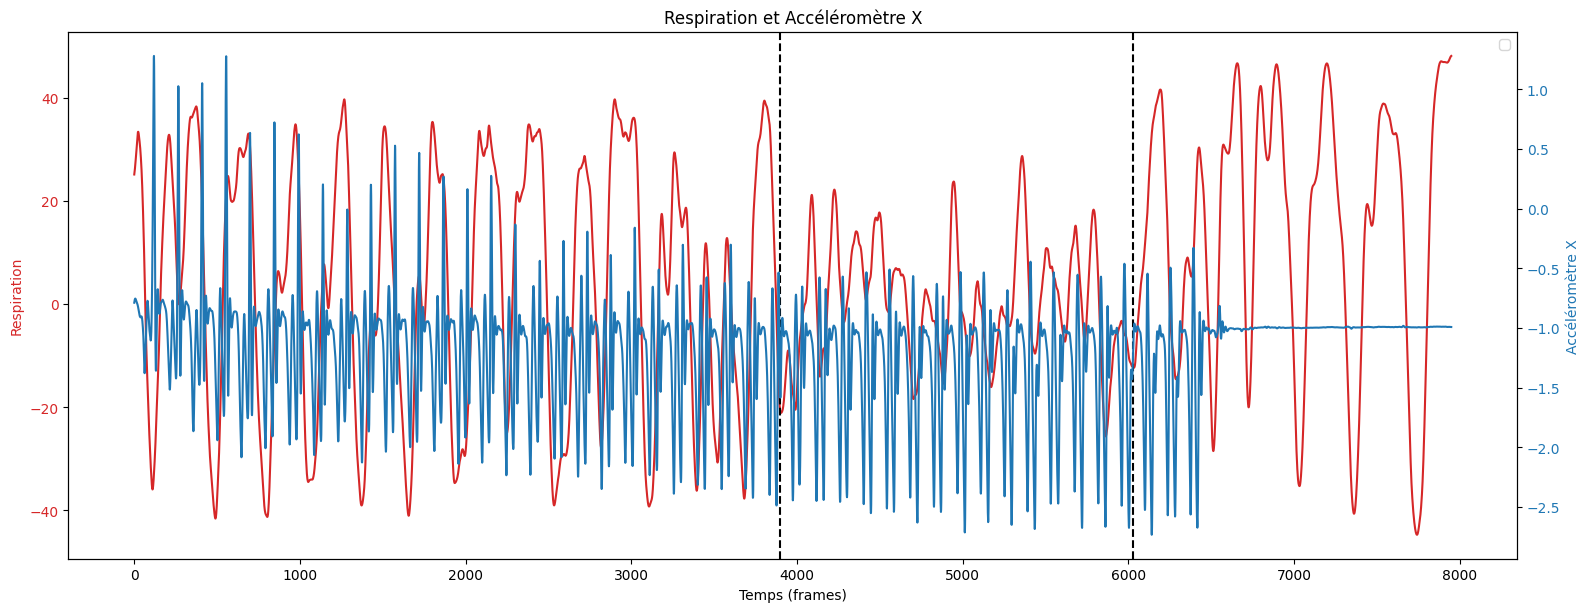

C:\Users\hippo_kq2e550\AppData\Local\Temp\ipykernel_6676\2250235802.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


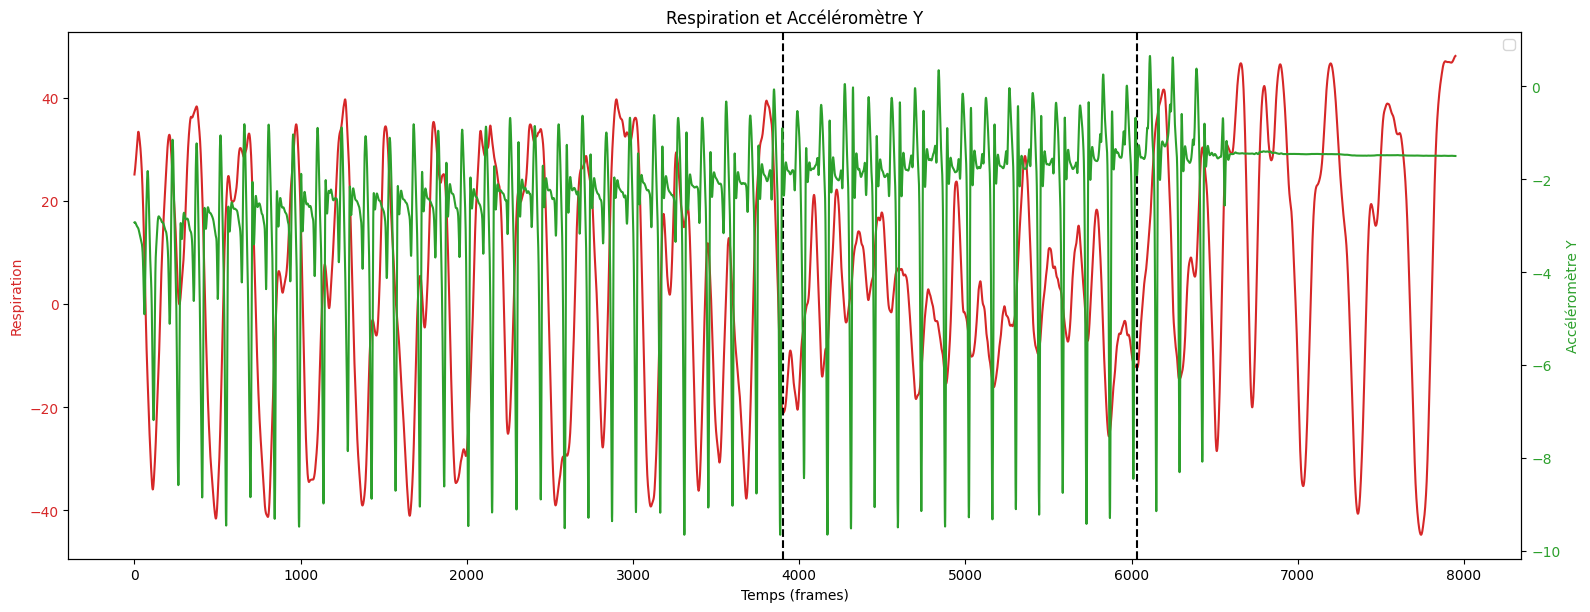

In [ ]:
#plot_resp_and_acc_from_session(session_1_results_julie)
plot_resp_and_acc_from_session(session_1_results_coco)

## Session 2

- Marcher en ligne droite pendant 20 secondes
- Course en montée de genoux
- Reprise de la respiration pendant 15 secondes + repos

In [ ]:
cutoff = 5
fs = 100
window_size_resp = 50

# Contextes et descriptions pour chaque segment
contexts = ["MARCHE", "MARCHE", "REPOS"]
descriptions = [
    "Marcher en ligne droite pendant 20 secondes sur la passerelle du 4e etage de l'epi 6 + Respiration normale",
    "Course en montee de genoux sur la passerelle du 4e etage de l'epi 6 + Respiration rapide",
    "Repos + Reprise de la respiration normale"]

In [ ]:
segmentation_points_s2 = [(600,3827),(3827,6000),(6000,7028)]
session_2_data = sessions['julie_session_2.txt']

# Traitement des sessions
session_2_results_julie = process_session_data(session_2_data, cutoff, fs, window_size_resp, segmentation_points_s2)

process_and_export_session(
    txt_path= r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Acquisition\julie_session_2.txt',
    session_id="2",
    session_results= session_2_results_julie,
    contexts=contexts,
    descriptions=descriptions,
    start_index=600)

Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_2_json\julie_session_2_Seq_1.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_2_json\julie_session_2_Seq_2.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_2_json\julie_session_2_Seq_3.json.


In [ ]:
segmentation_points_s2 = [(25,2400),(2400,4406),(4406,6040)]
session_2_data = sessions['coco_session_2.txt']

# Traitement des sessions
session_2_results_coco = process_session_data(session_2_data, cutoff, fs, window_size_resp, segmentation_points_s2)

process_and_export_session(
    txt_path= r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Acquisition\coco_session_2.txt',
    session_id="2",
    session_results= session_2_results_coco,
    contexts=contexts,
    descriptions=descriptions,
    start_index=25)

Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_2_json\coco_session_2_Seq_1.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_2_json\coco_session_2_Seq_2.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_2_json\coco_session_2_Seq_3.json.


### Plots Session 2

C:\Users\hippo_kq2e550\AppData\Local\Temp\ipykernel_6676\2250235802.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


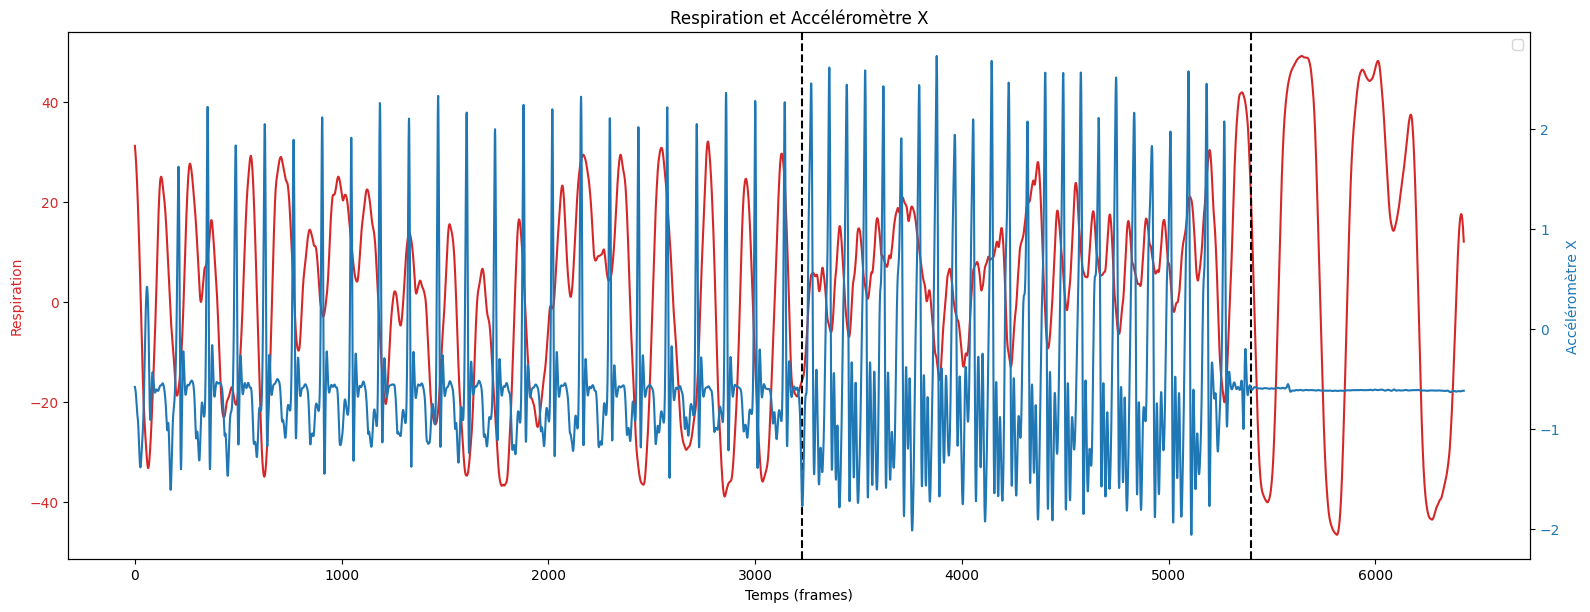

C:\Users\hippo_kq2e550\AppData\Local\Temp\ipykernel_6676\2250235802.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


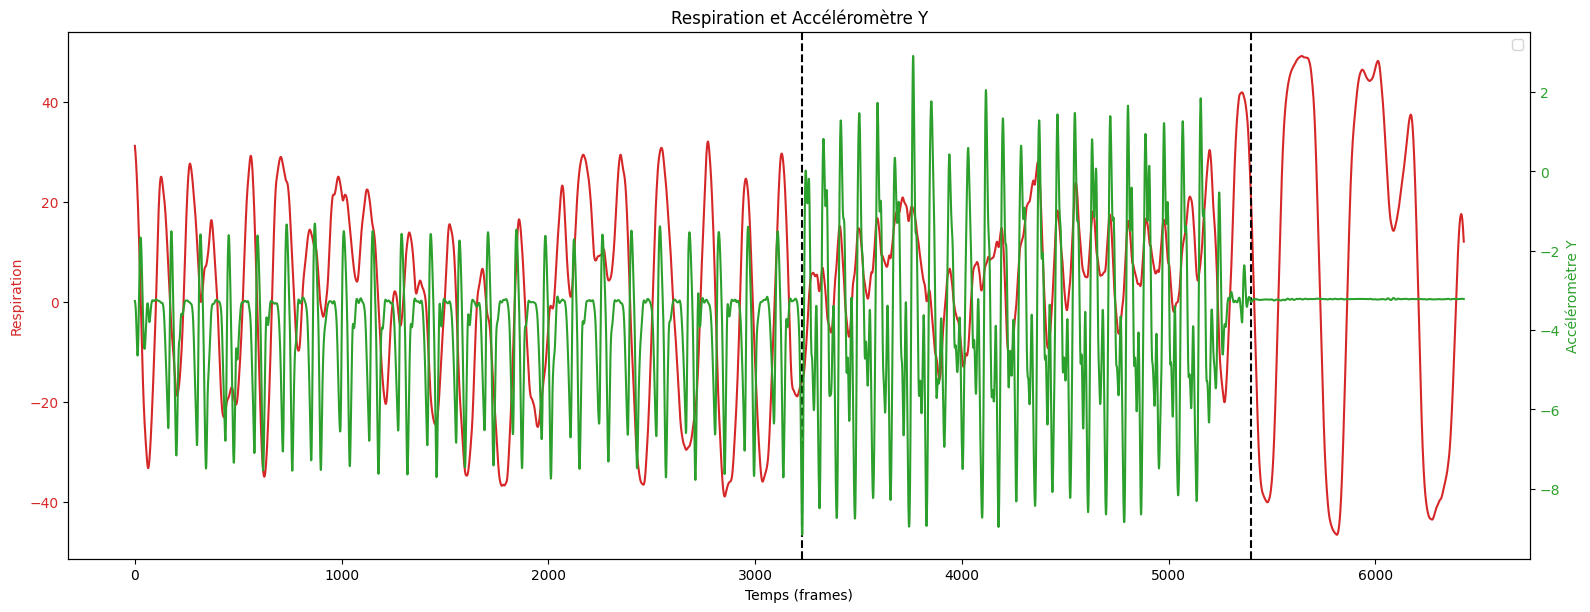

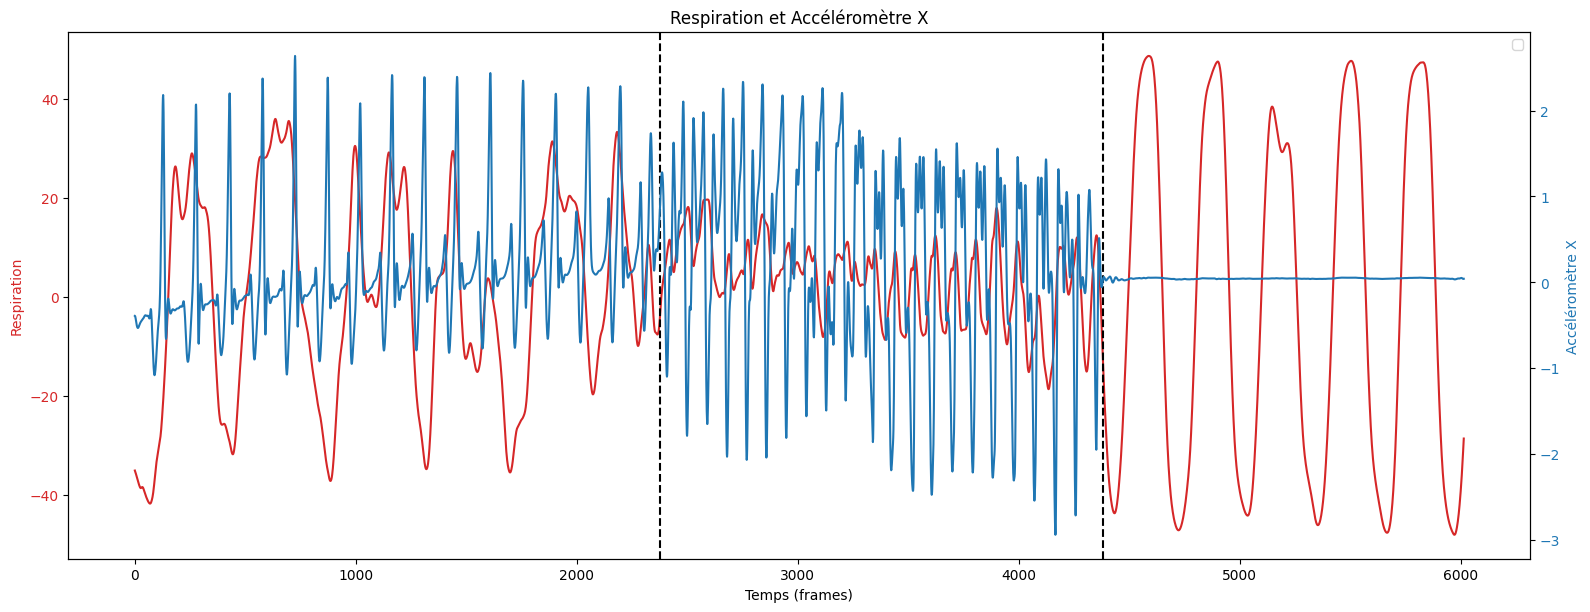

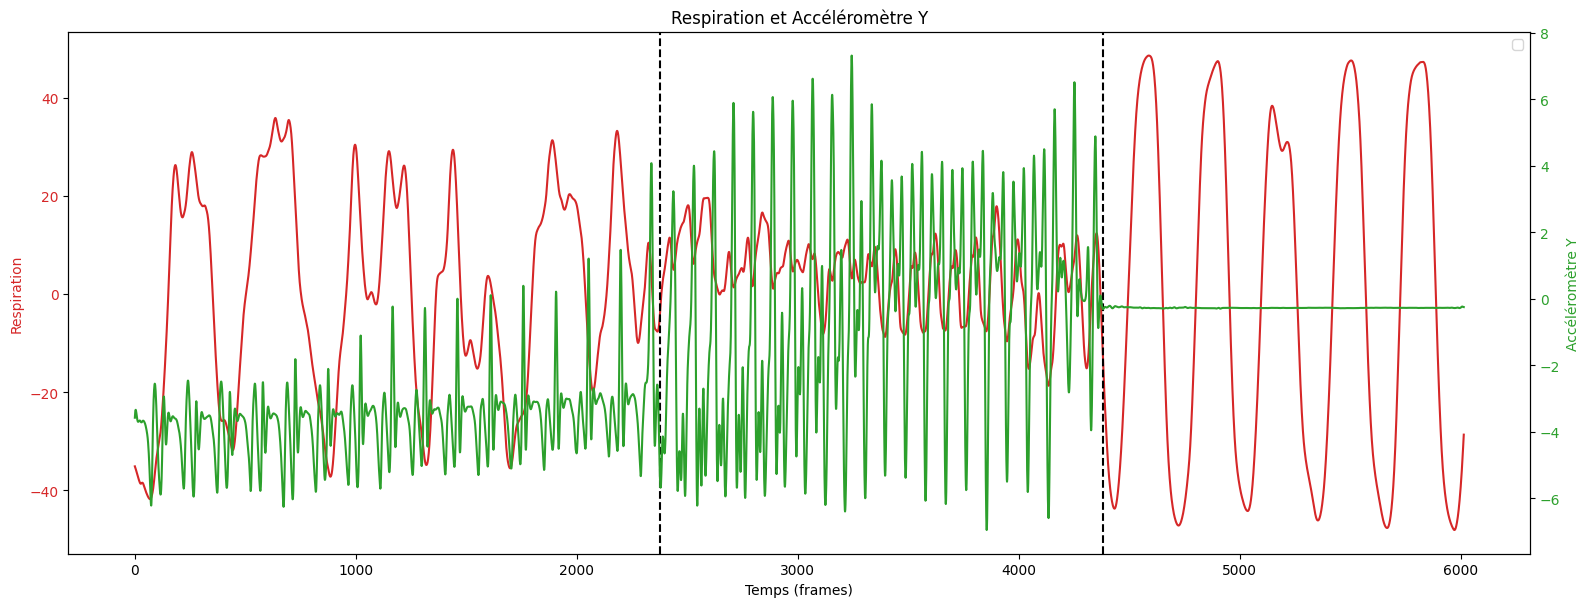

In [ ]:
plot_resp_and_acc_from_session(session_2_results_julie)
plot_resp_and_acc_from_session(session_2_results_coco)

# **Protocole 2**

## Session 3

- Apnée 15 secondes + Respiration normale pendant 30s
- Descente d'escalier + respiration
- Reprise de la respiration pendant 30s + Repos

In [ ]:
cutoff = 5
fs = 100
window_size_resp = 50

# Contextes et descriptions pour chaque segment
contexts = ["APNEE", "DESCENTE", "REPOS"]
descriptions = [
    "Repos dans la cage de l'escalier de l'epi 6 + Apnee",
    "Descente d'escalier + Respiration rapide",
    "Repos + Reprise de la respiration normale"]

In [ ]:
segmentation_points_s3 = [(25,2813),(2813,8094),(8094,8495)]
session_3_data = sessions['hippo_session_3.txt']
# Traitement des sessions
session_3_results_hippo = process_session_data(session_3_data, cutoff, fs, window_size_resp, segmentation_points_s3)

process_and_export_session(
    txt_path= r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Acquisition\hippo_session_3.txt',
    session_id="3",
    session_results= session_3_results_hippo,
    contexts=contexts,
    descriptions=descriptions,
    start_index=25)

Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_3_json\hippo_session_3_Seq_1.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_3_json\hippo_session_3_Seq_2.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_3_json\hippo_session_3_Seq_3.json.


In [ ]:
segmentation_points_s3 = [(40,2550),(2550,8815),(8815,10000)]
session_3_data = sessions['mumu_session_3.txt']
# Traitement des sessions
session_3_results_mumu = process_session_data(session_3_data, cutoff, fs, window_size_resp, segmentation_points_s3)

process_and_export_session(
    txt_path= r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Acquisition\mumu_session_3.txt',
    session_id="3",
    session_results= session_3_results_mumu,
    contexts=contexts,
    descriptions=descriptions,
    start_index=40)

Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_3_json\mumu_session_3_Seq_1.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_3_json\mumu_session_3_Seq_2.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_3_json\mumu_session_3_Seq_3.json.


### Plots Session 3

C:\Users\hippo_kq2e550\AppData\Local\Temp\ipykernel_6676\2250235802.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


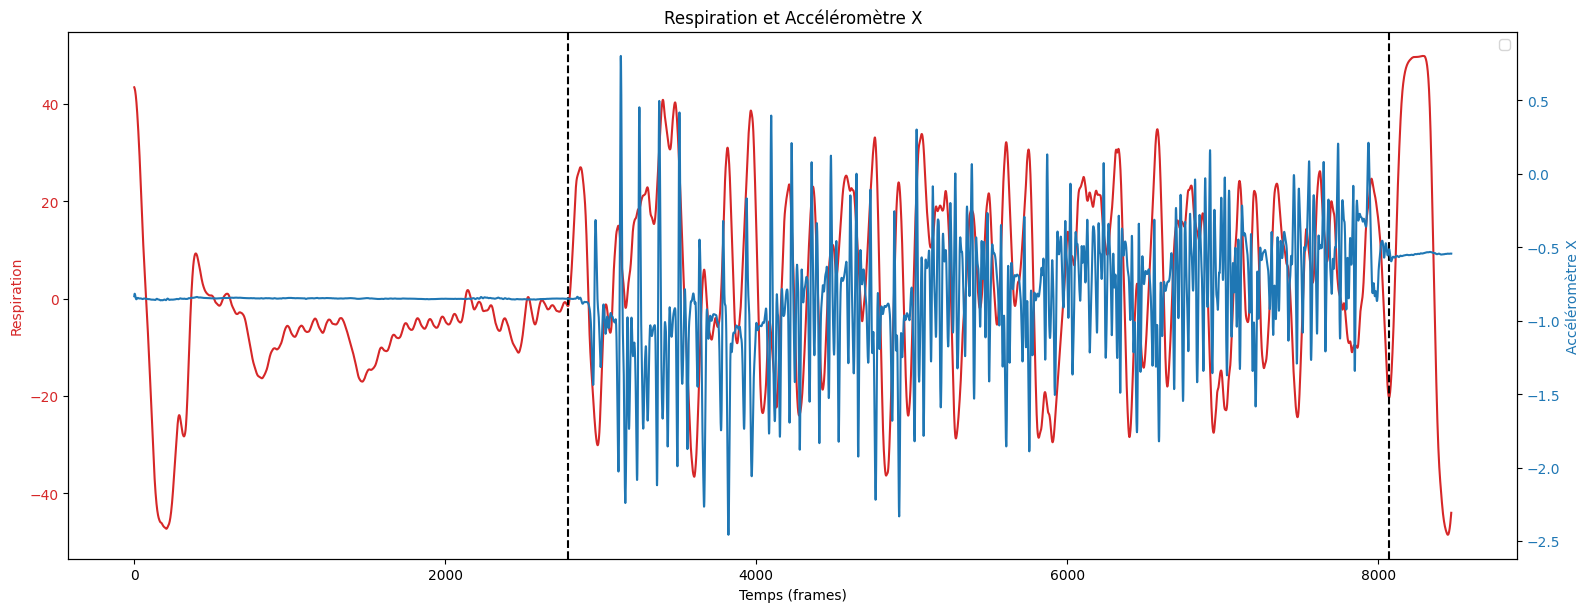

C:\Users\hippo_kq2e550\AppData\Local\Temp\ipykernel_6676\2250235802.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


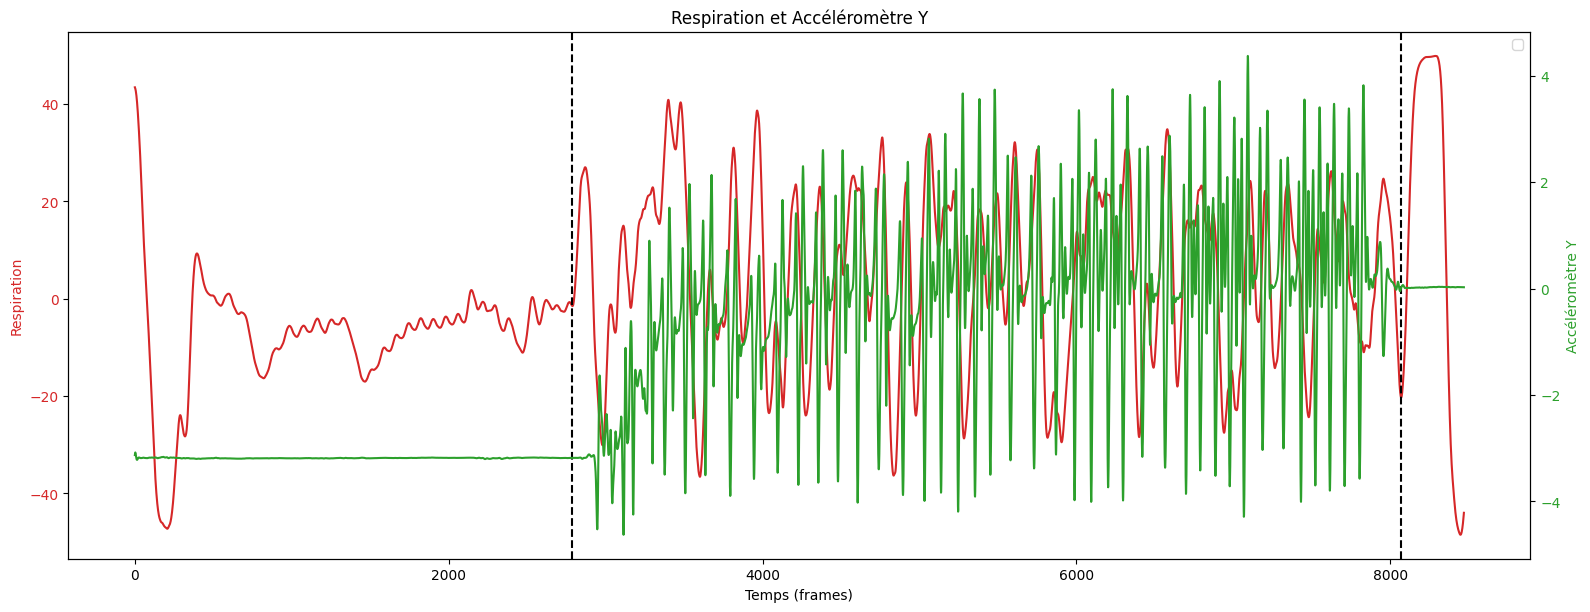

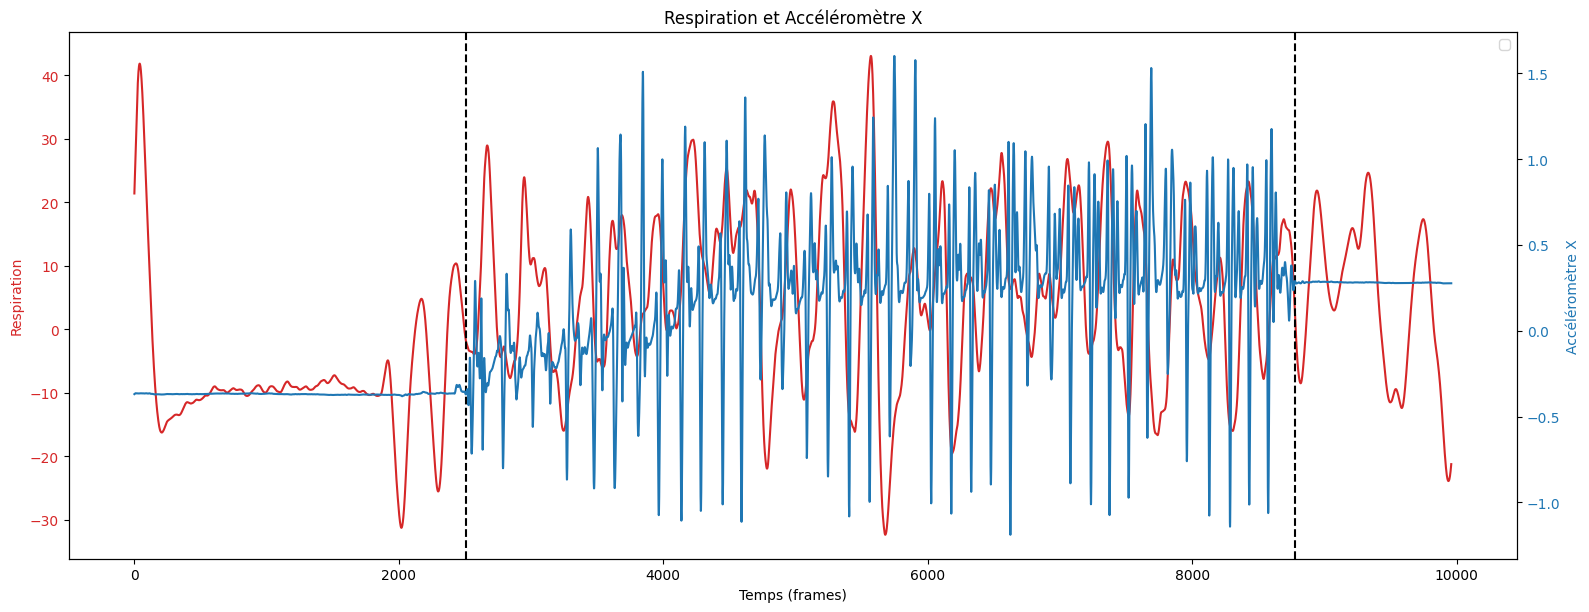

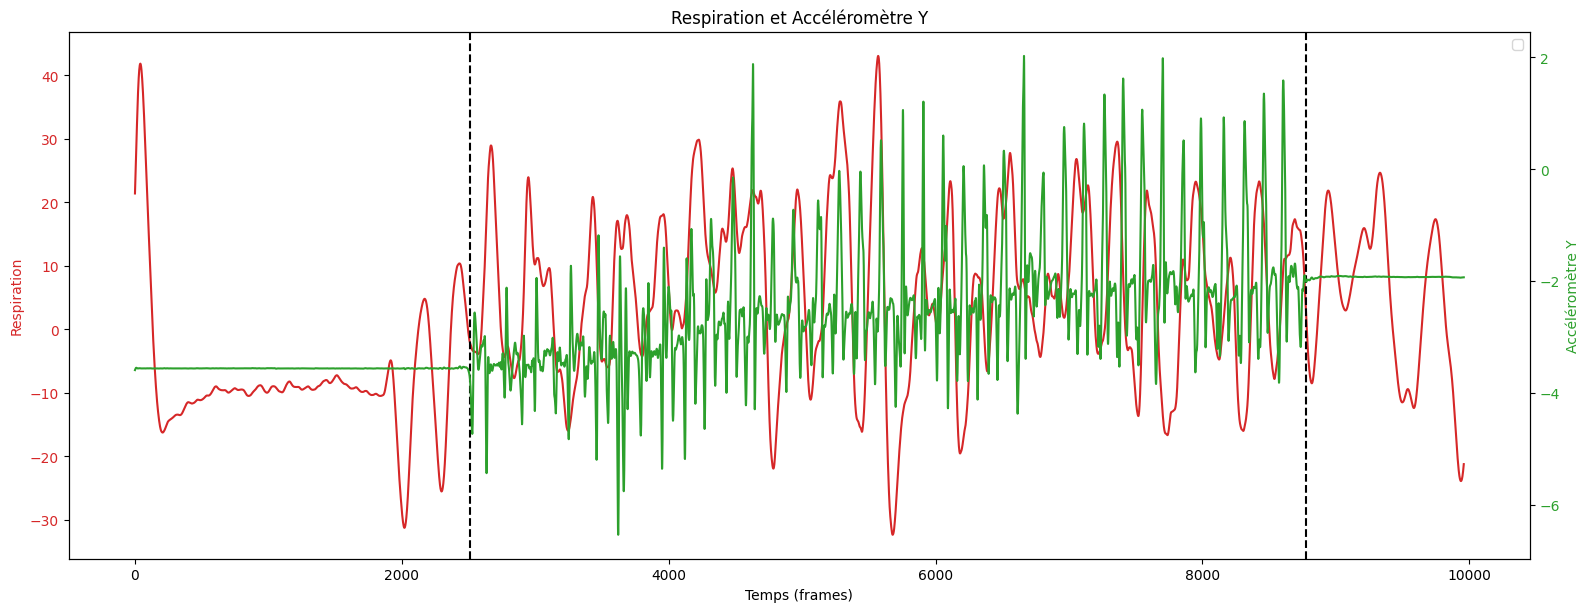

In [ ]:
plot_resp_and_acc_from_session(session_3_results_hippo)
plot_resp_and_acc_from_session(session_3_results_mumu)

## Session 4

- Respiration normale + Marche
- Montée de 4 étages
- Reprise de la respiration pendant 30s + Repos

In [ ]:
cutoff = 5
fs = 100
window_size_resp = 50

# Contextes et descriptions pour chaque segment
contexts = ["MARCHE", "MONTEE", "REPOS"]
descriptions = [
    "Marche dans la rue de l'ecole + Respiration normale",
    "Montee les 4 etages de l'epi 6 + Respiration rapide",
    "Repos + Reprise de la respiration normale "]

In [ ]:
segmentation_points_s4 = [(102,1132),(1132,6660),(6660,7255)]
session_4_data = sessions['hippo_session_4.txt']
# Traitement des sessions
session_4_results_hippo = process_session_data(session_4_data, cutoff, fs, window_size_resp, segmentation_points_s4)
process_and_export_session(
    txt_path= r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Acquisition\hippo_session_4.txt',
    session_id="4",
    session_results= session_4_results_hippo,
    contexts=contexts,
    descriptions=descriptions,
    start_index=102)

Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_4_json\hippo_session_4_Seq_1.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_4_json\hippo_session_4_Seq_2.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_4_json\hippo_session_4_Seq_3.json.


In [ ]:
segmentation_points_s4 = [(0,1160),(1160,6580),(6580,7250)]
session_4_data = sessions['mumu_session_4.txt']
# Traitement des sessions
session_4_results_mumu = process_session_data(session_4_data, cutoff, fs, window_size_resp, segmentation_points_s4)

process_and_export_session(
    txt_path= r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Acquisition\mumu_session_4.txt',
    session_id="4",
    session_results= session_4_results_mumu,
    contexts=contexts,
    descriptions=descriptions,
    start_index=0)

Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_4_json\mumu_session_4_Seq_1.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_4_json\mumu_session_4_Seq_2.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_4_json\mumu_session_4_Seq_3.json.


### Plots Session 4

C:\Users\hippo_kq2e550\AppData\Local\Temp\ipykernel_6676\2250235802.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


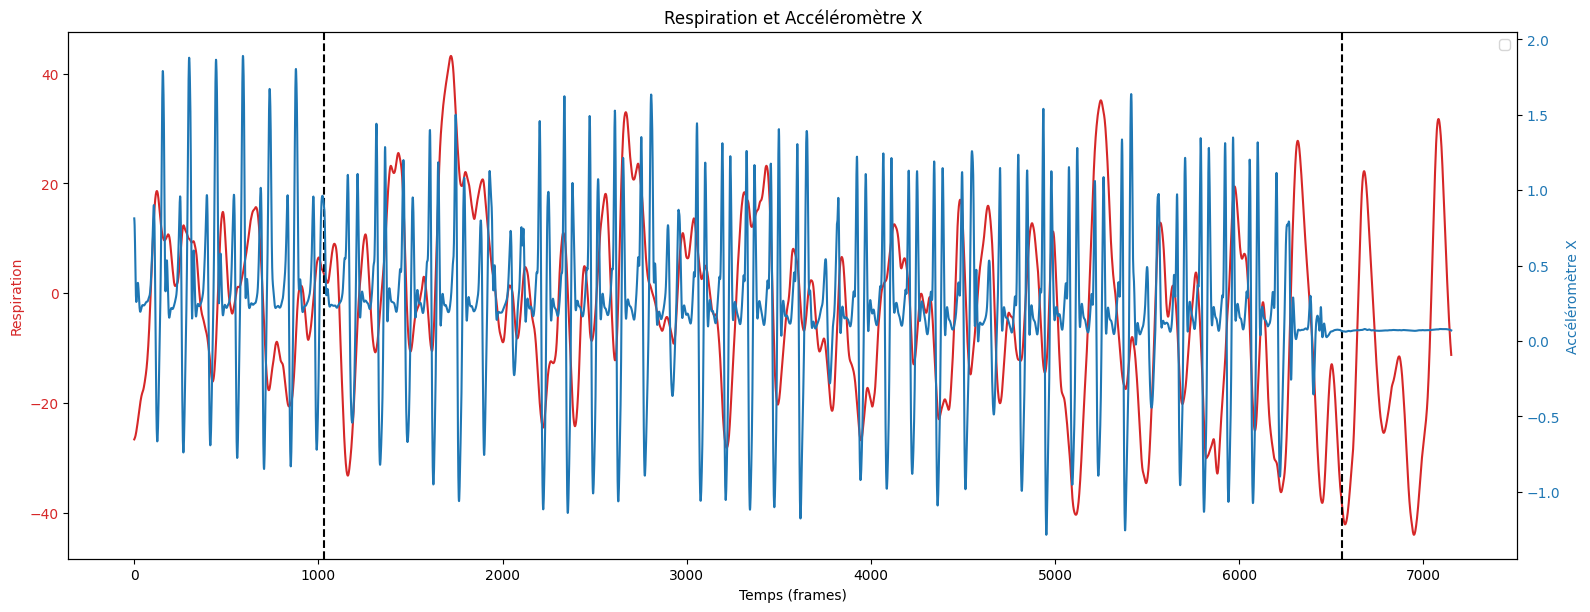

C:\Users\hippo_kq2e550\AppData\Local\Temp\ipykernel_6676\2250235802.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


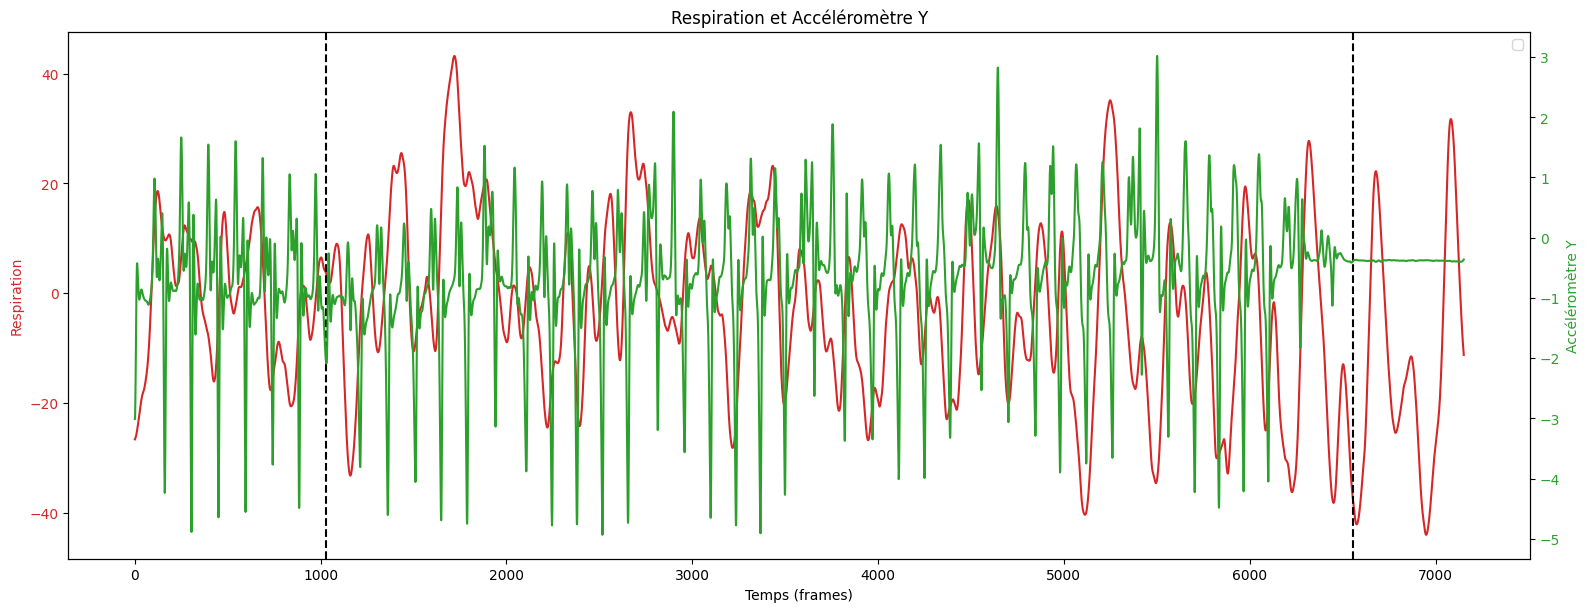

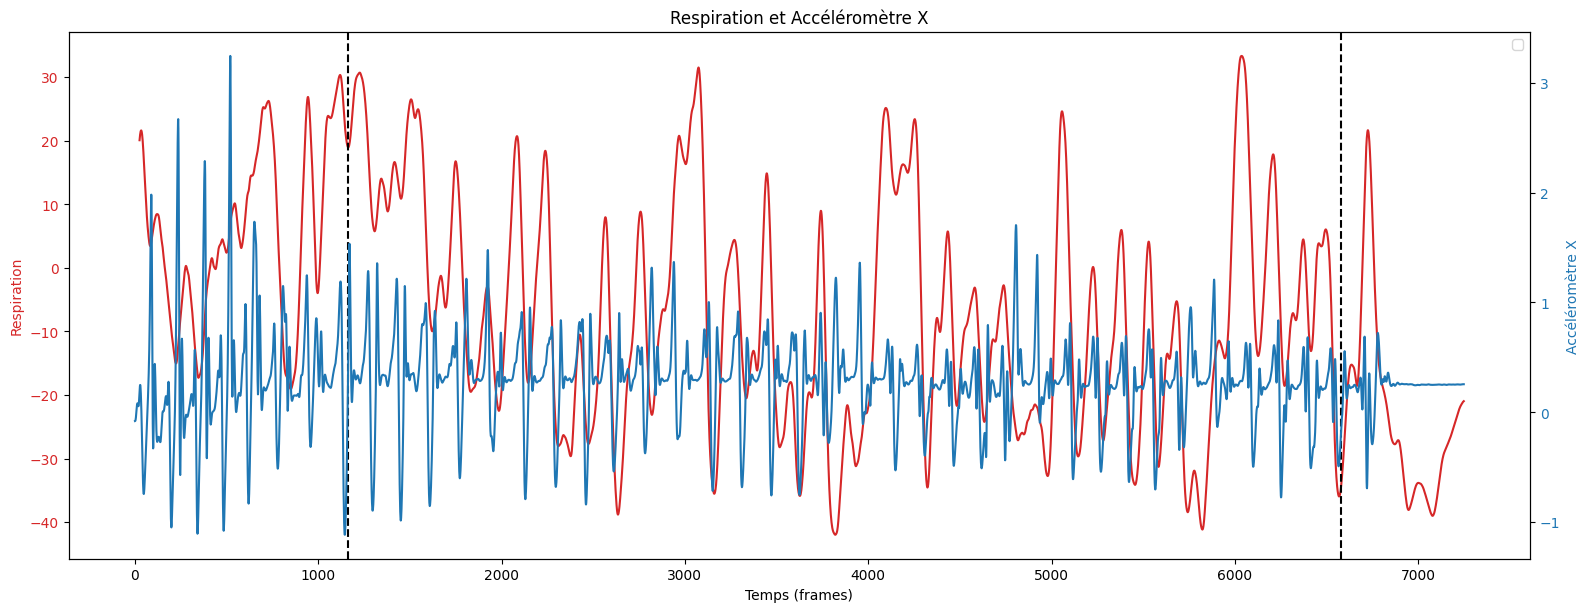

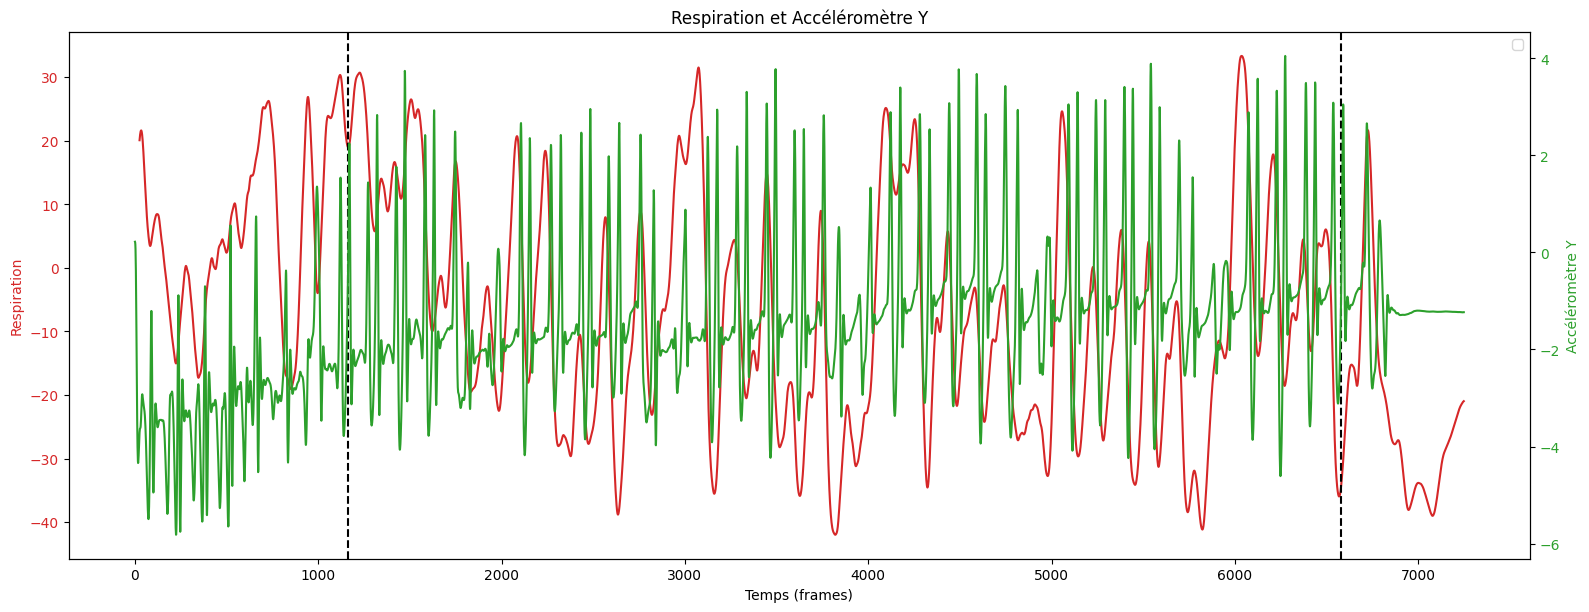

In [ ]:
plot_resp_and_acc_from_session(session_4_results_hippo)
plot_resp_and_acc_from_session(session_4_results_mumu)

# **Protocole 3**

## Session speed_step

- Marche lente 15s
- Marche moyenne 15s
- Marche rapide 15s

In [ ]:
cutoff = 5
fs = 100
window_size_resp = 50

# Contextes et descriptions pour chaque segment
contexts = ["MARCHE", "MARCHE", "MARCHE"]
descriptions = [
    "Marche lente dans la rue de l'ecole",
    "Marche normale dans la rue de l'ecole",
    "Marche rapide dans la rue de l'ecole"]

In [ ]:
segmentation_points_s5 = [(25,981),(981,2072),(2072,2956)]
session_5_data = sessions['hippo_session_5.txt']

# Traitement des sessions
session_5_results_hippo = process_session_data(session_5_data, cutoff, fs, window_size_resp, segmentation_points_s5)
process_and_export_session(
    txt_path= r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Acquisition\hippo_session_5.txt',
    session_id="5",
    session_results= session_5_results_hippo,
    contexts=contexts,
    descriptions=descriptions,
    start_index=20)

Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_5_json\hippo_session_5_Seq_1.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_5_json\hippo_session_5_Seq_2.json.
Exportation réussie de C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals\session_5_json\hippo_session_5_Seq_3.json.


### PLOTs Session 5

C:\Users\hippo_kq2e550\AppData\Local\Temp\ipykernel_6676\2250235802.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


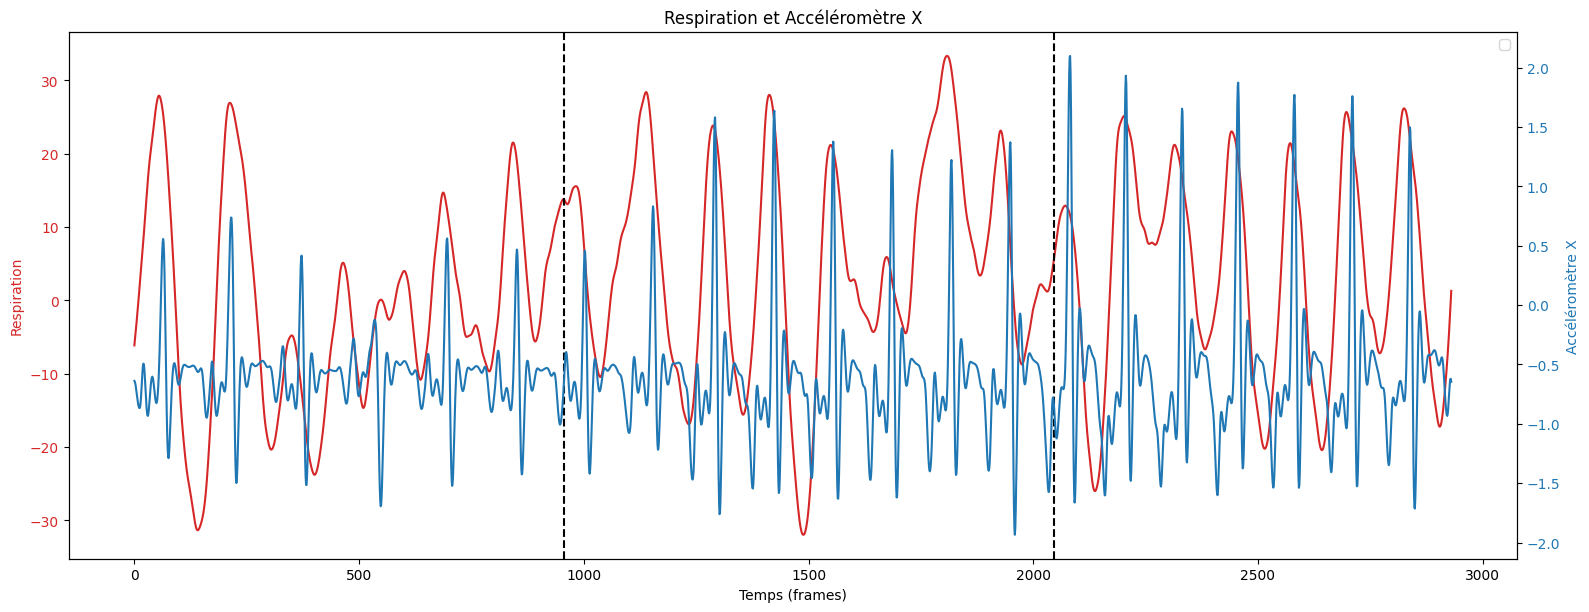

C:\Users\hippo_kq2e550\AppData\Local\Temp\ipykernel_6676\2250235802.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


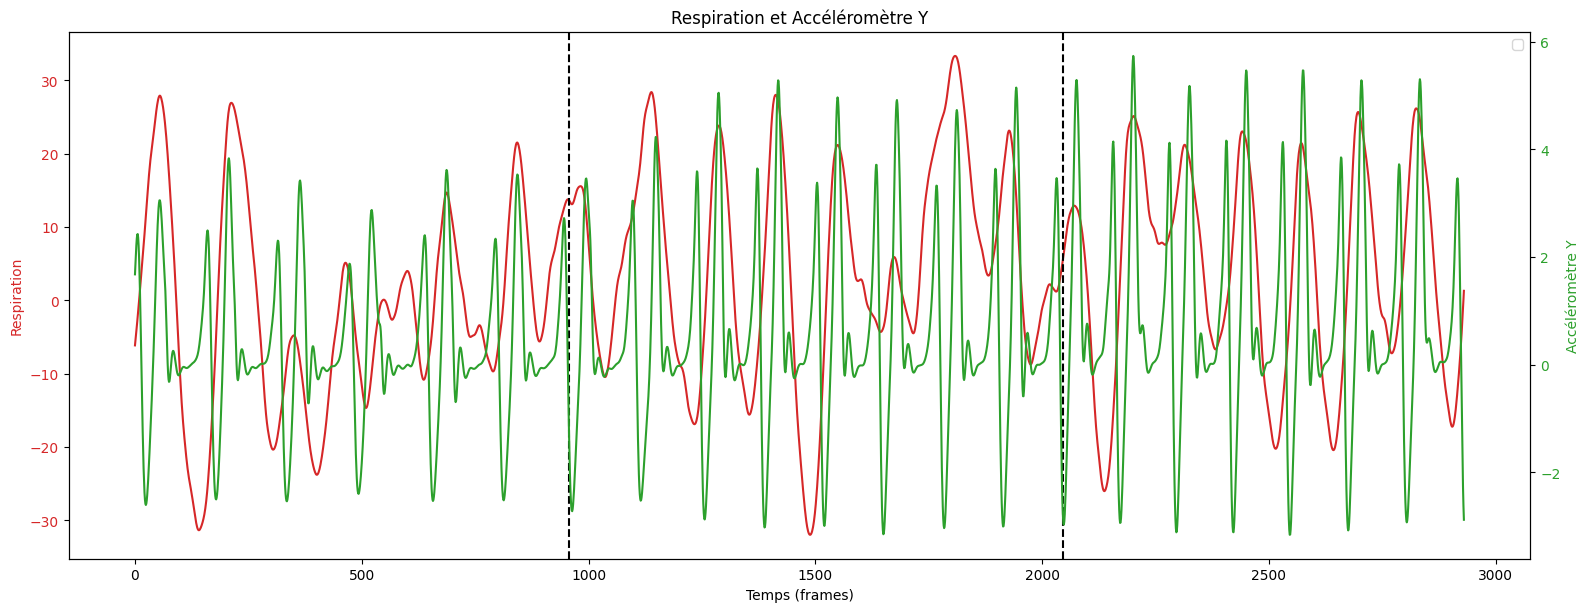

In [ ]:
plot_resp_and_acc_from_session(session_5_results_hippo)

# **Requêtes**

In [ ]:
#identifiant privé : 56167G
#mot de passe : 6#Qrau5Ta%
#identifiant public : E7
#X-Auth : Basic NTYxNjdHOjYjUXJhdTVUYSU=

## DELETE ##

In [ ]:
import requests
import json
import base64

privateStudentId = '56167G'
userPwd = '6#Qrau5Ta%'

userIdAndPwd = '{}:{}'.format(privateStudentId, userPwd)
encodedBytes = base64.b64encode(userIdAndPwd.encode('utf-8'))
userIdAndPwdBASE64 = encodedBytes.decode('utf-8')
authContent = 'Basic {}'.format(userIdAndPwdBASE64)

httpHeaders = {'X-Auth': authContent, 'Content-Type': 'application/x-www-form-urlencoded'}

# List of directories
directories = ['S1', 'S2', 'S3', 'S4', 'S5']

# URI racine du Web Service pour une requête http GET
rootUri = 'https://www.gaalactic.fr/~sev_5106e/ws/physioWeb'

# Loop through directories
for directory in directories:
    # Loop through sequence IDs (you can adjust the range as needed)
    for sequenceId in range(1, 4):  # Change the range as needed
        # Construction de l'URI complet
        fullUri = '{}/{}/{}'.format(rootUri, directory, sequenceId)

        # Exécution de la requête http DELETE et récupération de la réponse http du serveur
        httpAnswer = requests.delete(fullUri, headers=httpHeaders)

        # Test sur le code de statut de la réponse http
        if httpAnswer.status_code == 200:
            httpAnswerStructuredContent = json.loads(httpAnswer.text)
            print('\n')
            print(httpAnswerStructuredContent)
            print('\n')
        else:
            print('\n')
            print("Le serveur a rencontré une erreur : {}".format(httpAnswer.status_code))
            print("\n")



{'code': 'D00', 'résumé': 'REQUETE_EFFACEMENT_DONNEES_OK', 'libellé': "La suppression de la séquence de données de la base de données du serveur s'est correctement déroulée.", 'datasets': [{'studentId': 'E7', 'sessions': {'S1': {'sequences': [{'sequenceId': 1, 'deviceId': '00:07:80:65:DF:99', 'sequenceStartDateTime': '2024-09-17 15:14:53', 'sequenceContext': 'MARCHE', 'sequenceDescription': "Marche sur la passerelle du 4e etage de l'epi 6 + Respiration normale", 'sequenceStructure': ['INDEX', 'ACC_VERTICAL', 'ACC_HORIZONTAL', 'RESP_THORAX'], 'sequenceSamplingRate': 125, 'sequenceResolution': 16, 'sequenceRowNumber': 3900, 'deletedRowNumer': 3900}, {'sequenceId': 2, 'deviceId': '00:07:80:65:DF:99', 'sequenceStartDateTime': '2024-09-17 15:15:24', 'sequenceContext': 'APNEE', 'sequenceDescription': "Marche sur la passerelle du 4e etage de l'epi 6 + Apnee", 'sequenceStructure': ['INDEX', 'ACC_VERTICAL', 'ACC_HORIZONTAL', 'RESP_THORAX'], 'sequenceSamplingRate': 125, 'sequenceResolution': 1

## Test POST ##

In [ ]:
import os
import requests
import json
import base64

privateStudentId = '56167G'
userPwd = '6#Qrau5Ta%'

userIdAndPwd = '{}:{}'.format(privateStudentId, userPwd)
encodedBytes = base64.b64encode(userIdAndPwd.encode('utf-8'))
userIdAndPwdBASE64 = encodedBytes.decode('utf-8')
authContent = 'Basic {}'.format(userIdAndPwdBASE64)

httpHeaders = {'X-Auth': authContent, 'Content-Type': 'application/x-www-form-urlencoded'}

# List of directories
directories = ['session_1_json', 'session_2_json', 'session_3_json', 'session_4_json', 'session_5_json']

# Base path
base_path = r'C:\Users\hippo_kq2e550\OneDrive\Desktop\E4-E5\Modules_E4_E5\Télémed\Segmented_signals'

# URI of the Web Service
uri = 'https://www.gaalactic.fr/~sev_5106e/ws/physioWeb/E7'

# Loop through directories
for directory in directories:
    # Full path of the directory
    dir_path = os.path.join(base_path, directory)

    # Get a list of JSON files in the directory
    json_files = [f for f in os.listdir(dir_path) if f.endswith('.json')]

    # Loop through the first three JSON files
    for i, json_file in enumerate(json_files[:3]):
        # Full path of the JSON file
        file_path = os.path.join(dir_path, json_file)

        # Open the JSON file
        with open(file_path, "r", encoding="utf-8") as file_handler:
            dataset = file_handler.read()

        # Prepare the data for the HTTP request
        httpData = {'dataset': dataset}

        # Send the HTTP POST request
        httpAnswer = requests.post(uri, data=httpData, headers=httpHeaders)

        # Process the HTTP response
        if httpAnswer.status_code == 200:
            httpAnswerStructuredContent = json.loads(httpAnswer.text)
            print('\n')
            print(httpAnswerStructuredContent)
            print('\n')
        else:
            print('\n')
            print("Le serveur a rencontré une erreur : {}".format(httpAnswer.status_code))
            print("\n")




{'code': 'P00', 'résumé': 'ENREGISTREMENT_SEQUENCE_DONNEES_OK', 'libellé': 'la séquence de données a bien été enregistrée sur le serveur.'}




{'code': 'P00', 'résumé': 'ENREGISTREMENT_SEQUENCE_DONNEES_OK', 'libellé': 'la séquence de données a bien été enregistrée sur le serveur.'}




{'code': 'P00', 'résumé': 'ENREGISTREMENT_SEQUENCE_DONNEES_OK', 'libellé': 'la séquence de données a bien été enregistrée sur le serveur.'}




{'code': 'P00', 'résumé': 'ENREGISTREMENT_SEQUENCE_DONNEES_OK', 'libellé': 'la séquence de données a bien été enregistrée sur le serveur.'}




{'code': 'P00', 'résumé': 'ENREGISTREMENT_SEQUENCE_DONNEES_OK', 'libellé': 'la séquence de données a bien été enregistrée sur le serveur.'}




{'code': 'P00', 'résumé': 'ENREGISTREMENT_SEQUENCE_DONNEES_OK', 'libellé': 'la séquence de données a bien été enregistrée sur le serveur.'}




{'code': 'P00', 'résumé': 'ENREGISTREMENT_SEQUENCE_DONNEES_OK', 'libellé': 'la séquence de données a bien été enregistrée sur le serve

## Test GET ##

In [ ]:
# Parse the JSON response to find the sampling rate
import requests
import json
import base64

# Données d'authentification
privateStudentId = '56167G'
userPwd = '6#Qrau5Ta%'
publicStudentId = "E7"
sessionId = "S2"
sequenceId = 1
info = False

# Création de l'en-tête d'authentification
userIdAndPwd = f'{privateStudentId}:{userPwd}'
authContent = 'Basic ' + base64.b64encode(userIdAndPwd.encode('utf-8')).decode('utf-8')
httpHeaders = {'X-Auth': authContent}

# URI de la requête
rootUri = 'https://www.gaalactic.fr/~sev_5106e/ws/physioWeb'
fullUri = f"{rootUri}/{publicStudentId}/{sessionId}/{sequenceId}"
if info:
    fullUri += "{info}"

# Exécution de la requête
httpAnswer = requests.get(fullUri, headers=httpHeaders)

# Vérification du statut et récupération de la fréquence d'échantillonnage
if httpAnswer.status_code == 200:
    data = httpAnswer.json()
    try:
        # Parcourir pour extraire le sampling rate
        sampling_rate = data['datasets'][0]['sessions'][sessionId]['sequences'][0]['sequenceSamplingRate']
        print(f"Sampling Rate: {sampling_rate} Hz")
    except (KeyError, IndexError) as e:
        print("Erreur lors de l'extraction du sampling rate:", e)
else:
    print(f"Erreur du serveur: {httpAnswer.status_code}")


Sampling Rate: 125 Hz


# GET, PLOT et Calcul de moyennes

In [ ]:
# Fonction pour lancer la requête et récupérer les données
def fetch_data():
    # Récupération des entrées de l'utilisateur
    public_student_id = public_student_id_entry.get()
    session_id = session_id_entry.get()
    sequence_id = sequence_id_entry.get()

    # Vérification des champs de saisie
    if not public_student_id or not session_id or not sequence_id:
        messagebox.showerror("Erreur", "Tous les champs doivent être remplis")
        return

    # Données d'authentification
    private_student_id = '56167G'
    user_pwd = '6#Qrau5Ta%'

    # Création de l'en-tête d'authentification
    user_id_and_pwd = f'{private_student_id}:{user_pwd}'
    auth_content = 'Basic ' + base64.b64encode(user_id_and_pwd.encode('utf-8')).decode('utf-8')
    http_headers = {'X-Auth': auth_content}

    # URI de la requête
    root_uri = 'https://www.gaalactic.fr/~sev_5106e/ws/physioWeb'
    full_uri = f"{root_uri}/{public_student_id}/{session_id}/{sequence_id}"

    # Exécution de la requête
    try:
        http_answer = requests.get(full_uri, headers=http_headers)
        http_answer.raise_for_status()  # Vérifie si la réponse est OK
        data = http_answer.json()

        # Extraction des données
        try:
            sampling_rate = data['datasets'][0]['sessions'][session_id]['sequences'][0]['sequenceSamplingRate']
            sequence_data = data['datasets'][0]['sessions'][session_id]['sequences'][0]
            data_values = sequence_data['data']
            sequence_structure = sequence_data['sequenceStructure']

            # Récupération des signaux
            signal_columns = {name: idx for idx, name in enumerate(sequence_structure)}

            # Extraction des signaux (en fonction de la structure des données)
            indices = [row[signal_columns['INDEX']] for row in data_values] if 'INDEX' in signal_columns else None
            acc_vertical = [row[signal_columns['ACC_VERTICAL']] for row in data_values] if 'ACC_VERTICAL' in signal_columns else None
            acc_horizontal = [row[signal_columns['ACC_HORIZONTAL']] for row in data_values] if 'ACC_HORIZONTAL' in signal_columns else None
            resp_thorax = [row[signal_columns['RESP_THORAX']] for row in data_values] if 'RESP_THORAX' in signal_columns else None
            resp_abdomen = [row[signal_columns['RESP_ABDOMEN']] for row in data_values] if 'RESP_ABDOMEN' in signal_columns else None

            # Fonction pour afficher les graphiques dans des fenêtres séparées
            def plot_signal(signal, title, peaks=None, color='b', peak_color='r'):
                plt.figure(figsize=(10, 4))
                plt.plot(signal, color=color)
                if peaks is not None:
                    plt.plot(peaks, np.array(signal)[peaks], 'x', color=peak_color)
                plt.title(title)
                plt.xlabel("Time")
                plt.ylabel("Amplitude")
                plt.grid(True)
                plt.show()

            # Calcul du rythme respiratoire (thoracique) et affichage
            if resp_thorax:
                resp_thorax_signal = np.array(resp_thorax)
                resp_thorax_peaks, _ = find_peaks(resp_thorax_signal, distance=sampling_rate * 2)
                resp_thorax_rate = (len(resp_thorax_peaks) / (len(resp_thorax_signal) / sampling_rate)) * 60
                plot_signal(resp_thorax_signal, "Rythme respiratoire (thoracique)", resp_thorax_peaks, color='b', peak_color='r')
            else:
                resp_thorax_rate = None

            # Calcul du rythme respiratoire (abdominal) et affichage
            if resp_abdomen:
                resp_abdomen_signal = np.array(resp_abdomen)
                resp_abdomen_peaks, _ = find_peaks(resp_abdomen_signal, distance=sampling_rate * 2)
                resp_abdomen_rate = (len(resp_abdomen_peaks) / (len(resp_abdomen_signal) / sampling_rate)) * 60
                plot_signal(resp_abdomen_signal, "Rythme respiratoire (abdominal)", resp_abdomen_peaks, color='g', peak_color='y')
            else:
                resp_abdomen_rate = None

            # Calcul de la cadence de pas (verticale) et affichage
            if acc_vertical:
                acc_vertical_signal = np.array(acc_vertical)
                step_vertical_peaks, _ = find_peaks(acc_vertical_signal, distance=sampling_rate * 0.5)
                step_vertical_cadence = (len(step_vertical_peaks) / (len(acc_vertical_signal) / sampling_rate)) * 60
                plot_signal(acc_vertical_signal, "Cadence de pas (verticale)", step_vertical_peaks, color='r', peak_color='b')
            else:
                step_vertical_cadence = None

            # Calcul de la cadence de pas (horizontale) et affichage
            if acc_horizontal:
                acc_horizontal_signal = np.array(acc_horizontal)
                step_horizontal_peaks, _ = find_peaks(acc_horizontal_signal, distance=sampling_rate * 0.5)
                step_horizontal_cadence = (len(step_horizontal_peaks) / (len(acc_horizontal_signal) / sampling_rate)) * 60
                plot_signal(acc_horizontal_signal, "Cadence de pas (horizontale)", step_horizontal_peaks, color='y', peak_color='g')
            else:
                step_horizontal_cadence = None

            # Calcul de la cadence de pas moyenne
            if step_vertical_cadence and step_horizontal_cadence:
                average_step_cadence = (step_vertical_cadence + step_horizontal_cadence) / 2
            else:
                average_step_cadence = step_vertical_cadence or step_horizontal_cadence

            # Calcul des moyennes
            if resp_thorax_rate and resp_abdomen_rate:
                average_resp_rate = (resp_thorax_rate + resp_abdomen_rate) / 2
            elif resp_thorax_rate:
                average_resp_rate = resp_thorax_rate
            else:
                average_resp_rate = resp_abdomen_rate

            # Affichage des résultats dans la fenêtre
            result_text.set(f"Description de la séquence: {sequence_data['sequenceDescription']}\n"
                            f"Rythme respiratoire (thoracique): {resp_thorax_rate:.2f} resp/min\n"
                            f"Rythme respiratoire (abdominal): {resp_abdomen_rate:.2f} resp/min\n"
                            f"Cadence de pas (verticale): {step_vertical_cadence:.2f} pas/min\n"
                            f"Cadence de pas (horizontale): {step_horizontal_cadence:.2f} pas/min\n"
                            f"Cadence de pas moyenne: {average_step_cadence:.2f} pas/min\n"
                            f"Rythme respiratoire moyen: {average_resp_rate:.2f} resp/min\n")

        except (KeyError, IndexError) as e:
            messagebox.showerror("Erreur de données", f"Erreur lors de l'extraction des données: {e}")
    except requests.exceptions.RequestException as e:
        messagebox.showerror("Erreur de requête", f"Erreur de requête HTTP: {e}")



# INTERFACE UTILISATEUR (GUI)

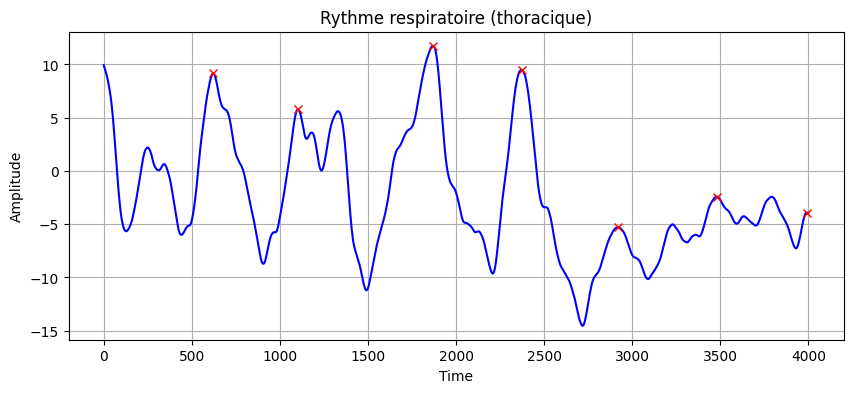

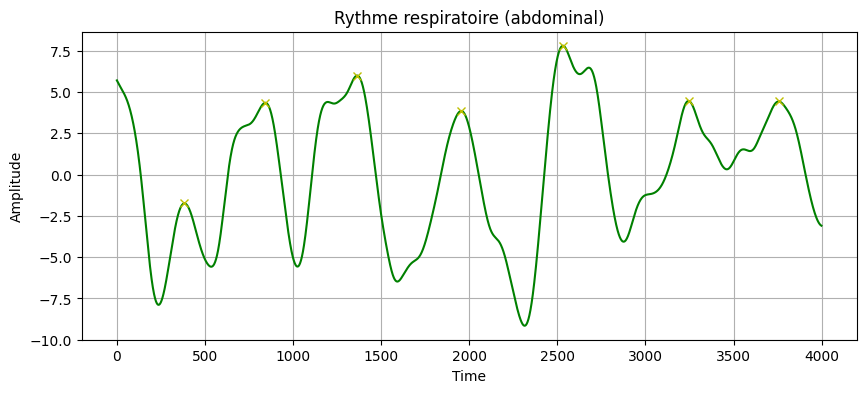

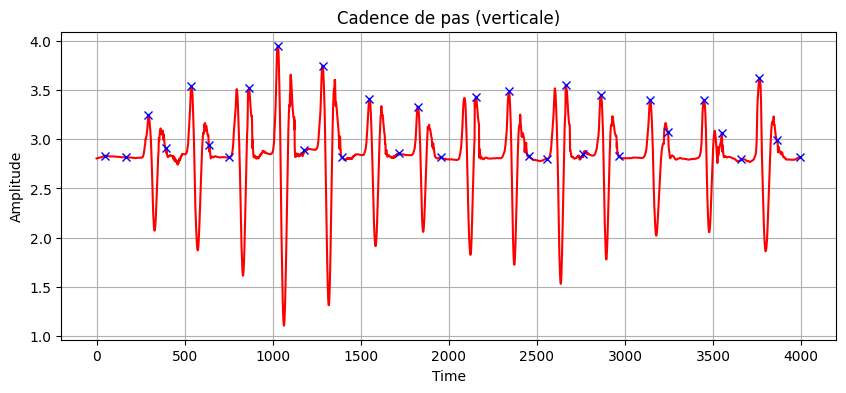

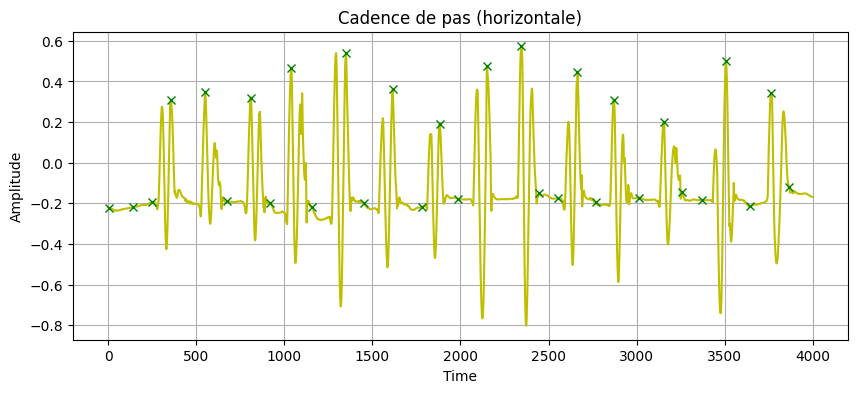

In [ ]:
# Création de la fenêtre principale
root = tk.Tk()
root.title("Analyse Physiologique")

# Frame pour les champs de saisie
frame_input = tk.Frame(root)
frame_input.grid(row=0, column=0, padx=20, pady=10)

# Labels et champs de saisie
tk.Label(frame_input, text="ID Publique: (de E1 à E24)").grid(row=0, column=0, padx=5, pady=5)
public_student_id_entry = tk.Entry(frame_input)
public_student_id_entry.grid(row=0, column=1, padx=5, pady=5)

tk.Label(frame_input, text="ID de session: (de 1 à 3)").grid(row=1, column=0, padx=5, pady=5)
session_id_entry = tk.Entry(frame_input)
session_id_entry.grid(row=1, column=1, padx=5, pady=5)

tk.Label(frame_input, text="ID de séquence: (de 1 à 3)").grid(row=2, column=0, padx=5, pady=5)
sequence_id_entry = tk.Entry(frame_input)
sequence_id_entry.grid(row=2, column=1, padx=5, pady=5)

# Bouton pour soumettre la requête
submit_button = tk.Button(frame_input, text="Analyser", command=fetch_data)
submit_button.grid(row=3, columnspan=2, pady=10)

# Label pour afficher les résultats textuels
result_text = tk.StringVar()
result_label = tk.Label(root, textvariable=result_text, justify="left")
result_label.grid(row=1, column=0, padx=20, pady=10)

# Lancer l'interface
root.mainloop()